In [3]:
!pip install peft transformers accelerate bitsandbytes datasets trl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import os
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, BitsAndBytesConfig
)

from peft import get_peft_model, LoraConfig, TaskType


In [5]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [13]:

df_liar = pd.read_csv("/content/drive/MyDrive/misinfo_project/liar/liar_train.csv")
df_fake = pd.read_csv("/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_train.csv")

df_train = pd.concat([df_liar, df_fake], ignore_index=True)
df_train.dropna(subset=["text", "label"], inplace=True)
df_train["label"] = df_train["label"].astype(int)


In [14]:

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=df_train["label"]
)


class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)


Class weights: tensor([0.7812, 1.3892])


In [15]:
model_name = "deepseek-ai/deepseek-llm-7b-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token


In [16]:
bnb_config = BitsAndBytesConfig(load_in_8bit=True)

base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    quantization_config=bnb_config,
    device_map="auto"
)

base_model.config.pad_token_id = tokenizer.pad_token_id

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/deepseek-llm-7b-base and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 3,940,352 || all params: 6,494,883,840 || trainable%: 0.0607


In [17]:
def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = Dataset.from_pandas(df_train)
train_dataset = train_dataset.map(tokenize, batched=True)
train_dataset = train_dataset.remove_columns(["text"])
train_dataset.set_format("torch")


Map:   0%|          | 0/10577 [00:00<?, ? examples/s]

In [18]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").to(torch.long)
        outputs = model(**inputs)
        logits = outputs.logits
        weight = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss_fn = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [19]:


training_args = TrainingArguments(
    output_dir="./deepseek_output",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    learning_rate=1e-5,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    fp16=False,
    bf16=False,
    optim="adamw_torch_fused"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [20]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
    class_weights=class_weights
)
trainer.train()

<ipython-input-18-31041ea34719>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
50,0.699100
100,0.701600
150,0.701400
200,0.705900
250,0.695400
300,0.696400
350,0.692300
400,0.694400
450,0.701500
500,0.705500


TrainOutput(global_step=3966, training_loss=0.6712463040335035, metrics={'train_runtime': 6563.2656, 'train_samples_per_second': 4.835, 'train_steps_per_second': 0.604, 'total_flos': 2.9595176508850176e+17, 'train_loss': 0.6712463040335035, 'epoch': 2.998109640831758})

In [22]:
def load_test_data(path):
    df = pd.read_csv(path).dropna(subset=["text", "label"])
    df["label"] = df["label"].astype(int)
    dataset = Dataset.from_pandas(df).map(tokenize, batched=True)
    dataset = dataset.remove_columns(["text"])
    dataset.set_format("torch")
    return dataset

# Paths
test_paths = {
    "LIAR": "/content/drive/MyDrive/misinfo_project/liar/liar_test.csv",
    "FakeNewsNet": "/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_test.csv"
}

# Evaluate and log
results = {}
for name, path in test_paths.items():
    test_data = load_test_data(path)
    output = trainer.predict(test_data)
    preds = torch.argmax(torch.tensor(output.predictions), dim=1)
    labels = output.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    accuracy = accuracy_score(labels, preds)
    results[name] = {
        "accuracy": accuracy, "precision": precision,
        "recall": recall, "f1": f1
    }
    print(f"{name} results:", results[name])


Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

LIAR results: {'accuracy': 0.6385161799526441, 'precision': 0.49002217294900224, 'recall': 0.4922048997772829, 'f1': 0.4911111111111111}


Map:   0%|          | 0/85 [00:00<?, ? examples/s]

FakeNewsNet results: {'accuracy': 0.5294117647058824, 'precision': 0.5178571428571429, 'recall': 0.6904761904761905, 'f1': 0.5918367346938775}


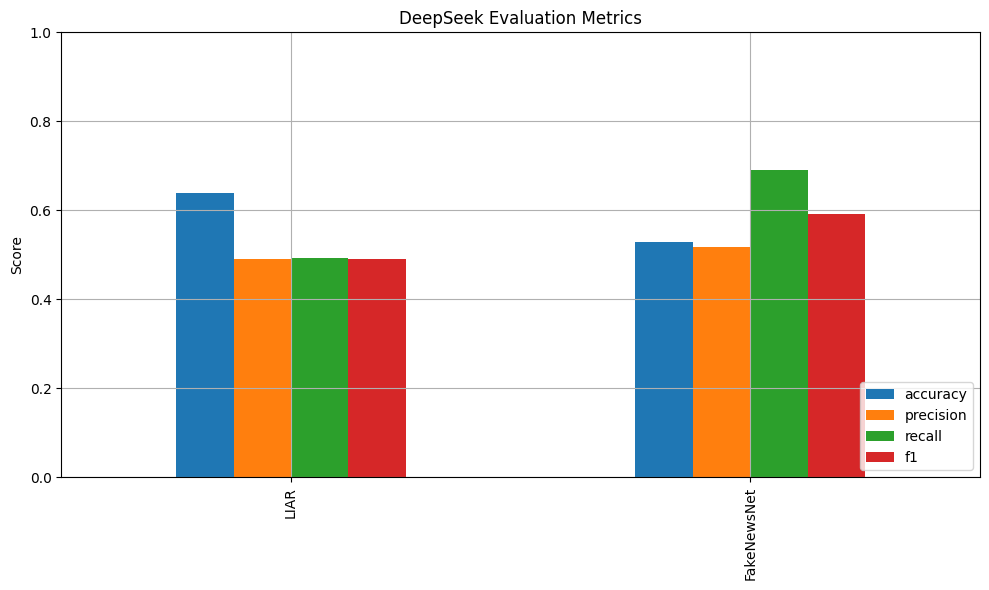

In [23]:
df_metrics = pd.DataFrame(results).T
df_metrics.plot.bar(figsize=(10, 6))
plt.title("DeepSeek Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
save_dir = "/content/drive/MyDrive/misinfo_project/models/deepseek_lora_final"

model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)




('/content/drive/MyDrive/misinfo_project/models/deepseek_lora_final/tokenizer_config.json',
 '/content/drive/MyDrive/misinfo_project/models/deepseek_lora_final/special_tokens_map.json',
 '/content/drive/MyDrive/misinfo_project/models/deepseek_lora_final/tokenizer.json')